# Clustering

Heretofore, all of our classification algorithms dealt with data that was labelled, and all the resulting algorithms were *supervised* (Note that PCA was unsupervised, but that was an algorithm for dimensionality reduction, not classification).  Here, we develop the entry-level member of a broad class of algorithms for fitting models that are not labelled, or so-called *unsupervised* classification algorithms.  To begin with, let's look at a new dataset, called the Old Faithful dataset which relates the occurrence time to the length of eruption for the Old Faithful geyser in Yellowstone National Park:
<img src="OldFaithful1948.jpg">
Let's load it into python. 


In [1]:
from __future__ import print_function,division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)

# Note that this dataset is delimited by an arbitrary number of spaces, hence the r'\s*' regular expression
X = pd.read_table('faithful.dat',skiprows=25,sep='\s+').values[:,1:]

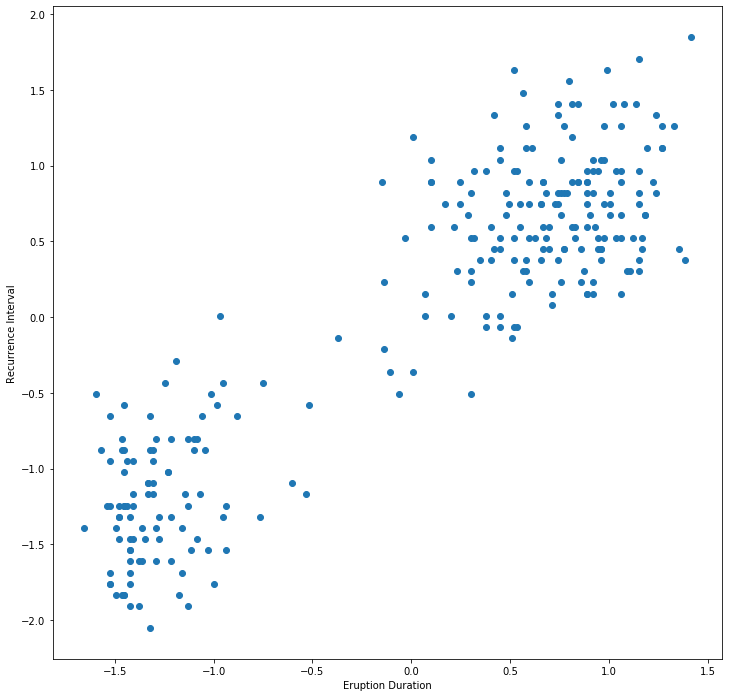

In [2]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X-X_mean)/X_std

plt.scatter(X[:,0],X[:,1])
plt.xlabel('Eruption Duration')
plt.ylabel('Recurrence Interval')
plt.show()

## Mixture of Gaussians

The general idea is that we'll initialize $k$ Gaussian distributions to model the feature distribution of each cluster, similarly to what we did with naive Bayes when we modeled the feature distribution of each class (note that we won't use the naive assumption here, although we certainly could).  These will begin randomly.  We'll then iteratively update class membership and the parameters of each cluster's Gaussian model (and the prior) until convergence.  Let's try MOG on this same dataset

In [ ]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt

# Note that this dataset is delimited by an arbitrary number of spaces, hence the r'\s*' regular expression
#X = pd.read_table('faithful.dat',skiprows=25,sep='\s+').values[:,1:]

Next, we can initialize a few matrices.  As before, we need to initialize a few things, in this case, class means $\mathbf{\mu}_k$, class covariances $\Sigma_k$, the class priors $\pi_k$, and the responsibility matrix $\Gamma$

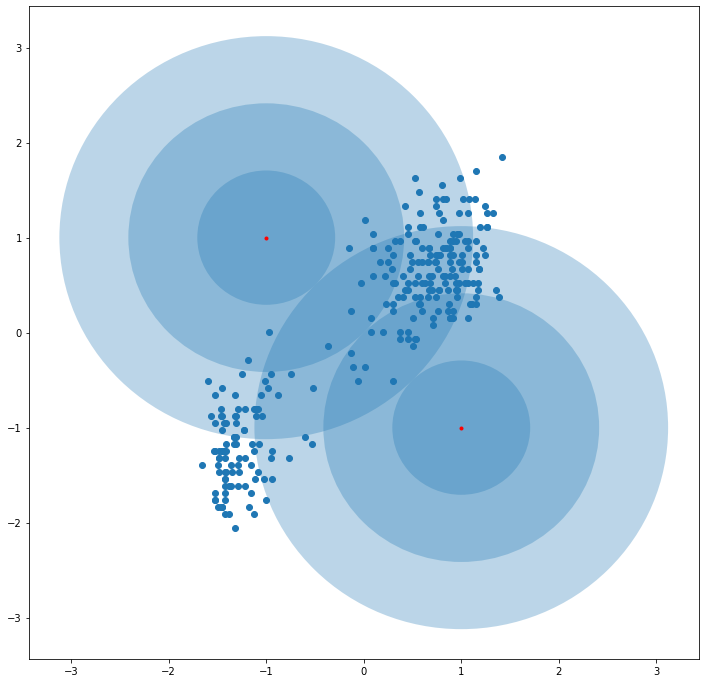

In [15]:
from scipy.stats import multivariate_normal as mvn
import sys
sys.path.insert(0,'./libraries/')
from plot_ellipse import plot_ellipse

m = len(X)
N = 2
n = 2

Pi = np.ones(N)/N
Sigma = np.ones((N,n,n))
Sigma[0,:,:] = np.eye(n)/2.
Sigma[1,:,:] = np.eye(n)/2.

# Initialize mu
Mu = np.vstack([[-1.0,1.0],[1.0,-1.0]])  

plt.figure()
plt.scatter(X[:,0],X[:,1])
plot_ellipse(Mu[0],Sigma[0],alpha=0.3)
plot_ellipse(Mu[1],Sigma[1],alpha=0.3)
Mu = np.array(Mu)
plt.plot(Mu[:,0],Mu[:,1],'r.')

First, we'll need a function to compute $\gamma$

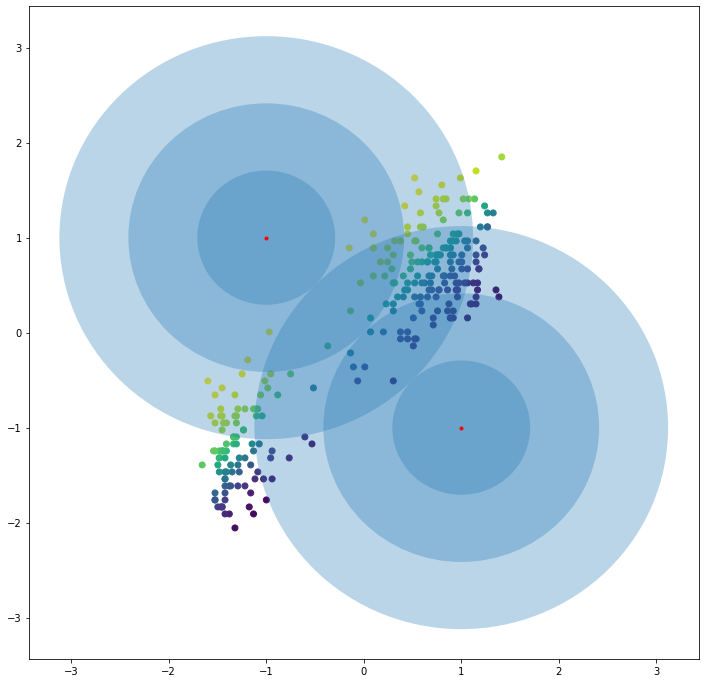

In [16]:
# Compute the fractional class membership given parameters mu, sigma, pi (and the data)
def calc_Gamma(Mu,Sigma,Pi,X):
    Gamma = np.zeros((m,N))/N
    for k in range(N):
        pi = Pi[k]
        mu = Mu[k]
        sigma = Sigma[k]
        for p in range(m):
            Gamma[p,k] = pi*np.exp(-0.5*np.dot(X[p] - Mu[k],np.dot(np.linalg.inv(Sigma[k]),X[p]-Mu[k])))
    Gamma /= Gamma.sum(axis=1)[:,np.newaxis]  
    Nk = Gamma.sum(axis=0)
    return Gamma,Nk

gamma,Nk = calc_Gamma(Mu,Sigma,Pi,X)
plt.figure()
plt.scatter(X[:,0],X[:,1],c=gamma[:,0])
plot_ellipse(Mu[0],Sigma[0],alpha=0.3)
plot_ellipse(Mu[1],Sigma[1],alpha=0.3)
Mu = np.array(Mu)
plt.plot(Mu[:,0],Mu[:,1],'r.')



Next, we'll use maximum likelihood to recompute the parameters:

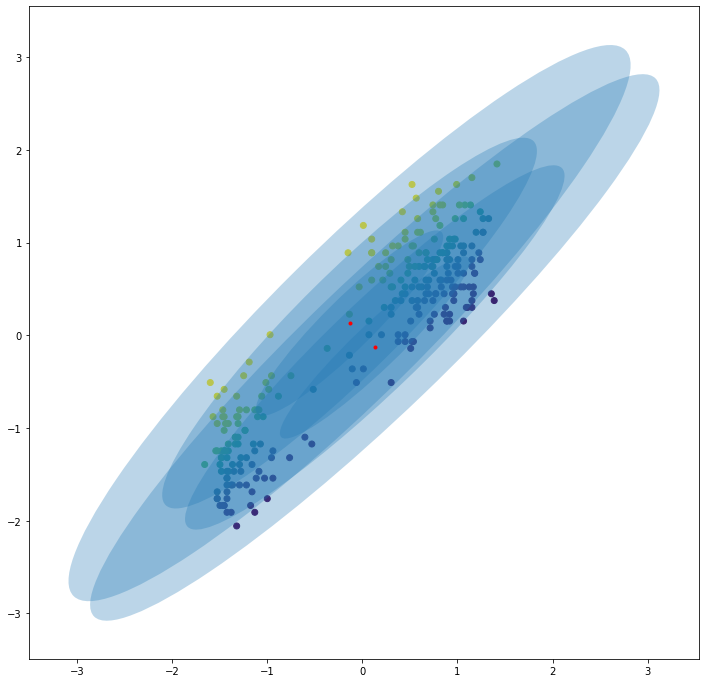

In [17]:
# Compute the parameters given fractional class membership (and the data)
def calc_parameters(Gamma,Nk,X):
    for k in range(N):
        Mu[k] = 1./Nk[k]*np.sum(Gamma[:,k][:,np.newaxis]*X,axis=0)
        r = (X-Mu[k])[:,:,np.newaxis]
        rhat = (Gamma[:,k][:,np.newaxis]*(X-Mu[k]))[:,np.newaxis]
        rT = np.transpose(r,(0,2,1))
        Sigma[k]=1./Nk[k]*np.tensordot(rhat,rT,([0],[0])).squeeze()
        Pi[k] = Nk[k]/m
    return Mu,Sigma,Pi

Mu,Sigma,Pi = calc_parameters(gamma,Nk,X)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=gamma[:,0])
plot_ellipse(Mu[0],Sigma[0],alpha=0.3)
plot_ellipse(Mu[1],Sigma[1],alpha=0.3)
Mu = np.array(Mu)
plt.plot(Mu[:,0],Mu[:,1],'r.')

Now that we have these two steps, we can simply iterate:

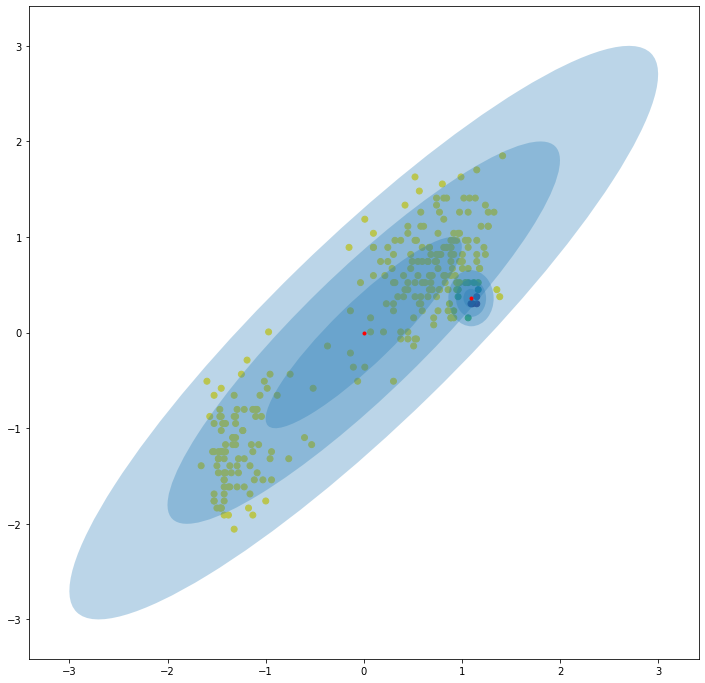

In [18]:
# Perform 10 iterations of EM
for i in range(20):
    # Compute fractional class membership
    Gamma,Nk = calc_Gamma(Mu,Sigma,Pi,X)
    
    # Compute normal distribution parameters
    Mu,Sigma,Pi = calc_parameters(Gamma,Nk,X)
    #print(Mu)

    # Plot resulting distributions
plt.figure()
plt.scatter(X[:,0],X[:,1],c=Gamma[:,0])
plot_ellipse(Mu[0],Sigma[0],alpha=0.3)
plot_ellipse(Mu[1],Sigma[1],alpha=0.3)
Mu = np.array(Mu)
plt.plot(Mu[:,0],Mu[:,1],'r.')

Incredible.  

As an aside, there's a similar (simpler) algorithm called K-means that's also useful to know (it actually corresponds to the limiting case where the entries in $\Sigma$ go to zero and all the priors are equal.  


K-means also proceeds iteratively, with two steps.  The first step is to assign points to clusters based on which mean they are closer to.  To organize this information, we'll store this class information in a one-hot matrix called $Z$.  It is straightforward to code this operation by creating a "distances" function which is called by a "form_Z" function that calls it.    


The first line computes the distance between every point and every mean.  The next three lines, constructs a new matrix $Z$ with a one in the column of the closest mean and a zero otherwise.  Finally, a new set of means are generated by taking the average of points assigned to that class mean.

In [19]:
# Initialize mu
Mu = np.vstack([[-1.0,1.0],[1.0,-1.0]])  

# Compute distance from cluster means to points
def distances(X,Mu):
    D = np.zeros((m,N))
    # Compare all points to all cluster means, and return Euclidean distance
    for i in range(m):
        for k in range(N):
            D[i,k] = np.sum((X[i]-Mu[k])**2)
    return D

distances(X,Mu)

# Generate a one-hot matrix of class membership
def form_Z(X,Mu):
    Z = np.zeros((m,N))
    D = distances(X,Mu)
    for z,d in zip(Z,D):
        z[np.argmin(d)] = 1
    return Z

Z = form_Z(X,Mu)
print (Z)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 

We now have made a classification based on distances to some probably pretty bad estimates of cluster centers.  It looks like this:

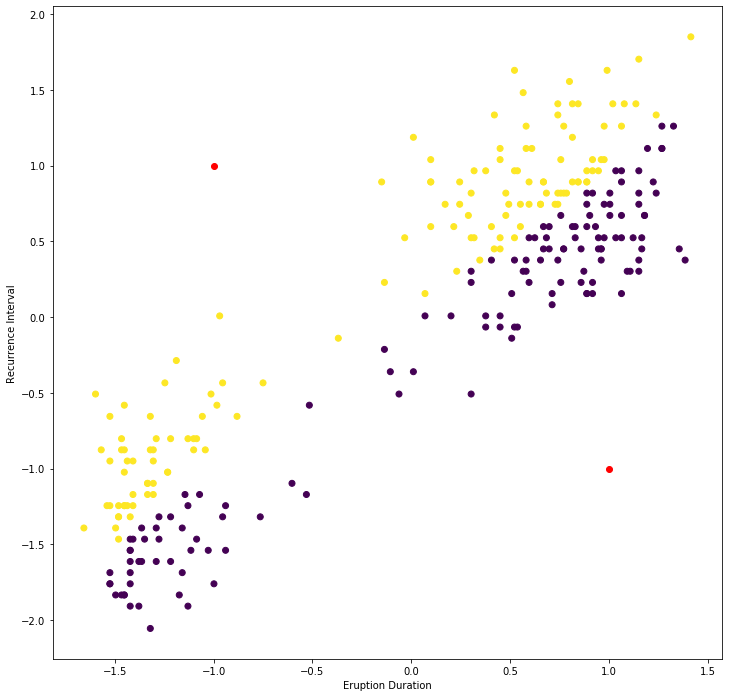

In [20]:
# Plot initial guesses
plt.scatter(X[:,0],X[:,1],c=Z[:,0])
plt.plot(Mu[:,0],Mu[:,1],'ro')

plt.xlabel('Eruption Duration')
plt.ylabel('Recurrence Interval')
plt.show()

But what should we do now?  It's absurd that this works, but now, let's just recompute the cluster means based on these newly assigned class memberships.

In [21]:
# Calculate the cluster means
def calc_mu(X,Z):
    Mu = np.zeros((N,n))
    for k in range(N):
        numerator = 0
        denominator = 0
        for i in range(m):
            numerator += Z[i,k]*X[i]
            denominator += Z[i,k]
        Mu[k] = numerator/denominator
    return Mu

Mu = calc_mu(X,Z)

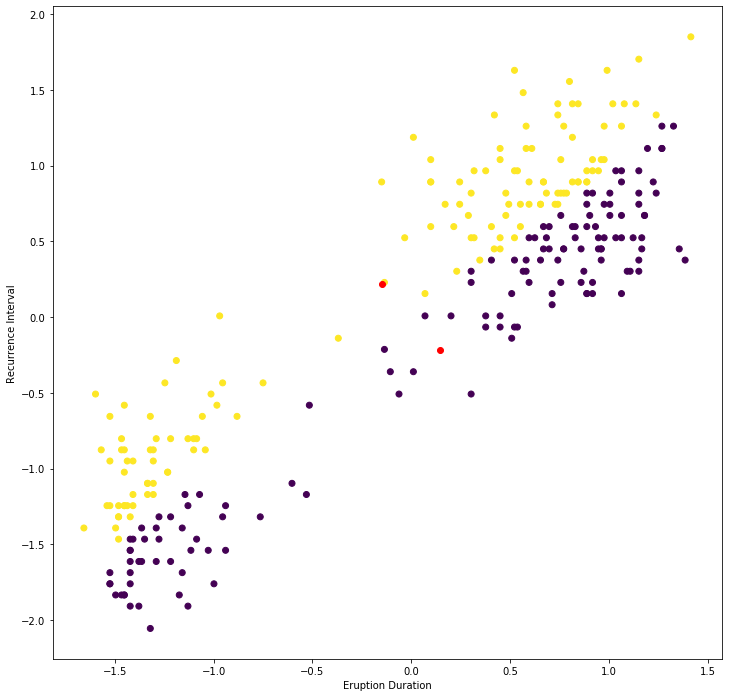

In [22]:
# Plot initial guesses
plt.scatter(X[:,0],X[:,1],c=Z[:,0])
plt.plot(Mu[:,0],Mu[:,1],'ro')

plt.xlabel('Eruption Duration')
plt.ylabel('Recurrence Interval')
plt.show()

Okay, that updated the means.  Now what?  Simply iterate.  As we do this, we'll keep track of the cost function, which is implicitly defined as 
$$ \sum_{i=1}^N \sum_{x\in S_k} \|x - \mu_k\|^2, $$
were $\mu_k$ is the mean of cluster $k$ and $S_k$ is the set of points assigned to cluster $k$.  

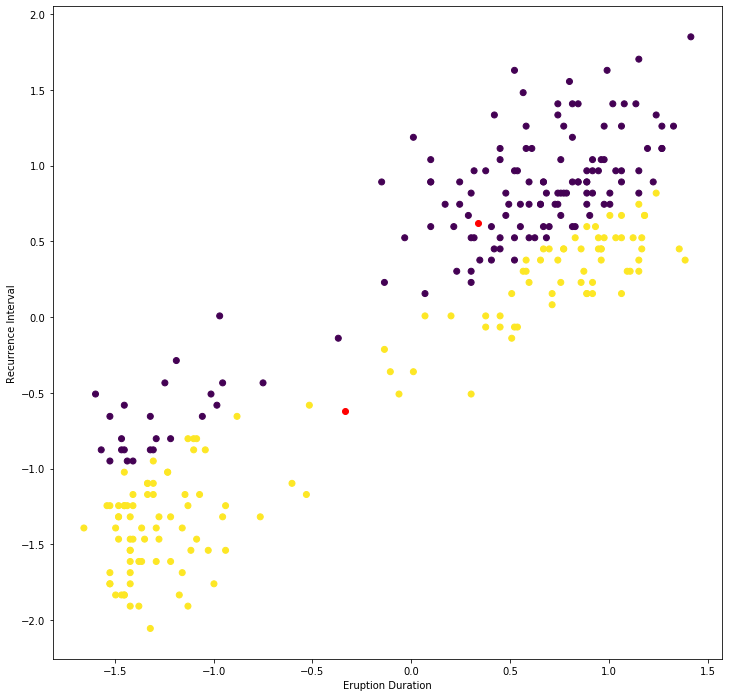

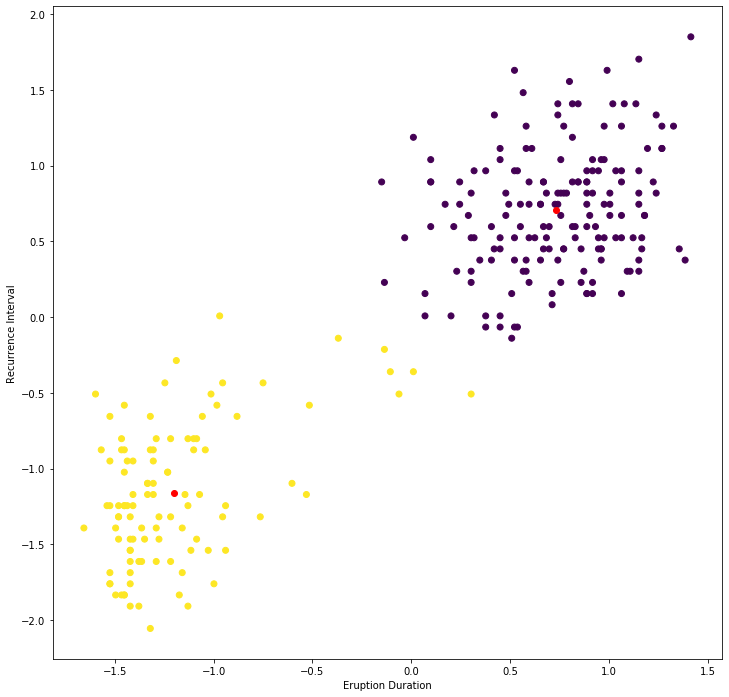

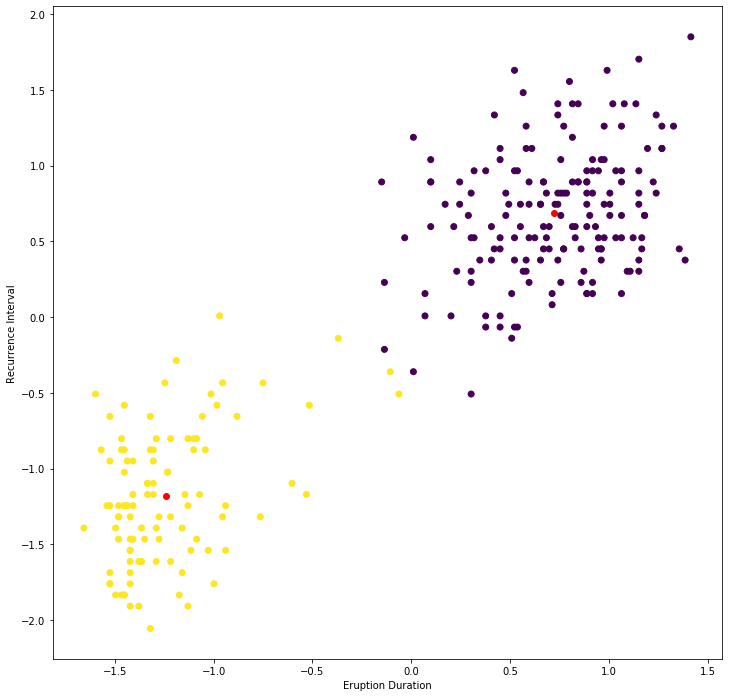

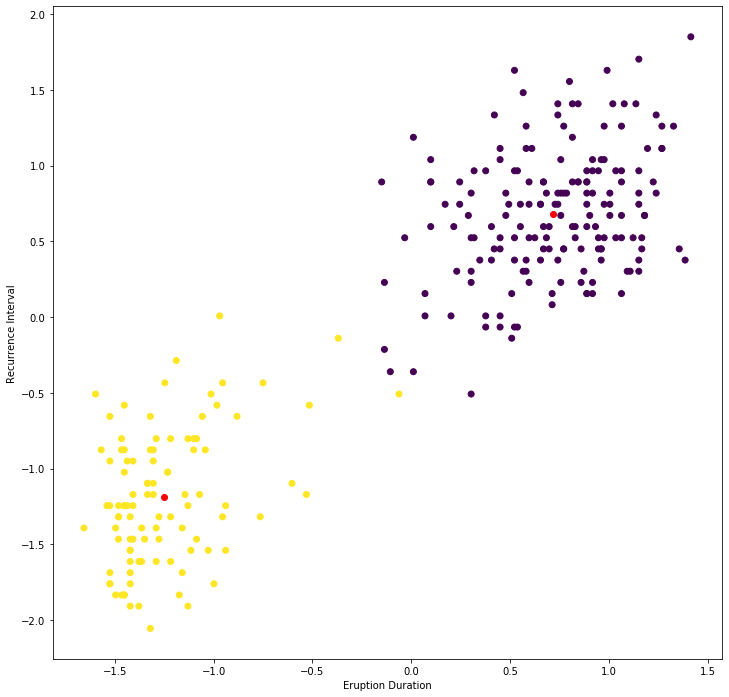

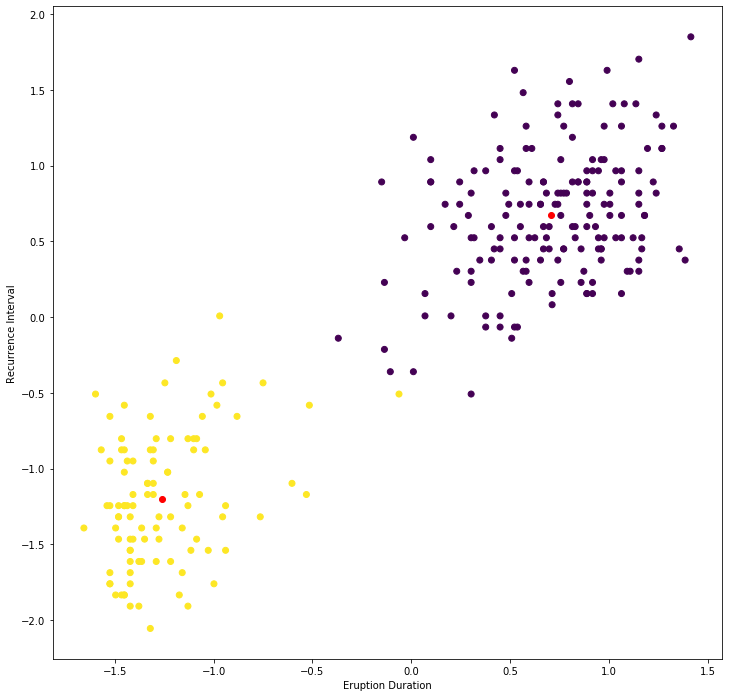

[[ 0.70970327  0.67674488]
 [-1.26008539 -1.20156744]]


In [23]:
# Compute the sum over cluster variances (this is the objective that k-means seeks to minimize)
def J(Z,Mu,X):
    JJ = 0
    for i in range(m):
        for k in range(N):
            JJ += Z[i,k]*np.sum((X[i]-Mu[k])**2)
    return JJ
        
# Calculate the initial misfit
Js = [J(Z,Mu,X)]

# Run five iterations of k-means
for i in range(5):
    # Form the one-hot class membership matrix
    Z = form_Z(X,Mu)
    # Calculate the cluster mean
    Mu = calc_mu(X,Z)
    
    # Compute the misfit (not necessary but useful for determining convergence)
    Js.append(J(Z,Mu,X))
      
    plt.figure()
    plt.scatter(X[:,0],X[:,1],c=np.argmax(Z,axis=1))
    plt.plot(Mu[:,0],Mu[:,1],'ro')

    plt.xlabel('Eruption Duration')
    plt.ylabel('Recurrence Interval')
plt.show()
print (Mu)

We can also look at the misfit values as we update:

In [24]:
print(Js)

[525.4410932291473, 407.930746146032, 82.03229495069378, 79.84335982641213, 79.63566081947319, 79.575959488277]


K-means is quite efficient, and converges to the optimal value in three iterations for this problem.  It is also much more robust than GMM, so makes for a good method to initialize GMM parameters.

## Model Selection (How many clusters should we use?)
The old faithful dataset is very easy to cluster because it's linearly separable.  Let's try a slightly more challenging example with the iris dataset.  

In [25]:
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)

import sys
sys.path.insert(0,'./libraries/')
from plot_ellipse import plot_ellipse

data = datasets.load_iris()

Recall that the iris dataset is 4-dimensional, but for the purposes of visualization and simplicity, we will use a principal components analysis (which we will discuss week after next) to reduce the dimensionality to two.  You can think of this as taking combinations of the 4 initial variables to make 2 new variables that best explain the variability in the data.

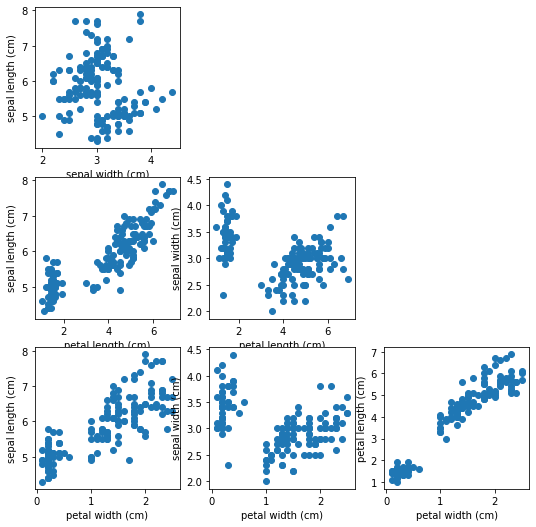

In [26]:
from sklearn import decomposition
pca = decomposition.PCA(0.95,whiten=False)
X = data.data

fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j])
            axs[i,j].set_xlabel(data['feature_names'][i])
            axs[i,j].set_ylabel(data['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.plot()


plt.show()

This time let's use the pre-fabricated GMM implementation in scikit learn.

In [27]:
from sklearn import mixture
mix = mixture.GaussianMixture(n_components=3,max_iter=1000)
mix.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

We can use this fitted model to predict the fractional membership matrix 

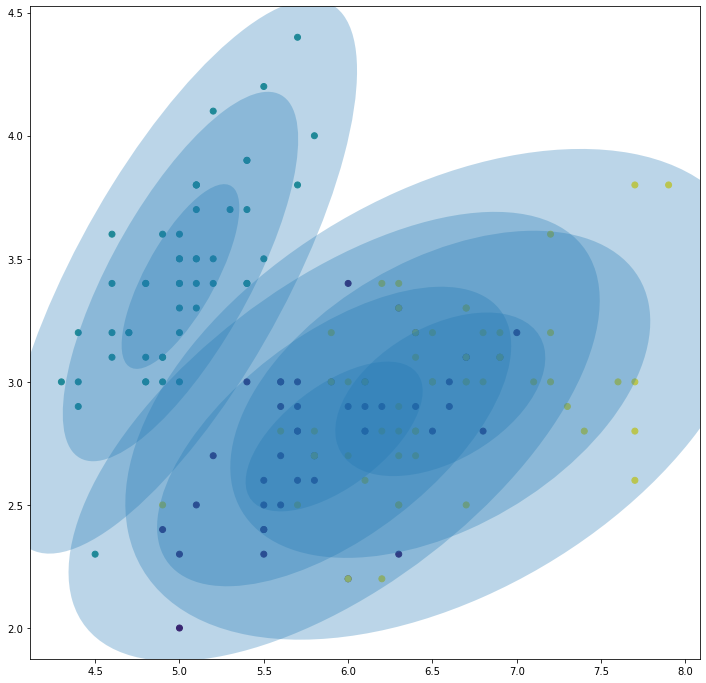

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0
 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [28]:
Z = mix.predict(X)
plt.scatter(X[:,0],X[:,1],c=Z)
for mu,sigma in zip(mix.means_,mix.covariances_):
    plot_ellipse(mu[:2],sigma[:2,:2],alpha=0.3)
plt.show()
print (Z)




In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data.target,Z)


array([[ 0, 50,  0],
       [45,  0,  5],
       [ 0,  0, 50]])

Not bad!  About the same accuracy as naive Bayes (which this algorithm is closely related to), but without the class labels.

But what if we didn't know the number of classes *a priori*?  This turns out to be one of the central questions of unsupervised learning, and there are many possible answers.  One of the easiest however is to fit the model several times using different numbers of classes, and to evaluate a model selection criterion such as BIC (Bayesian Information Criterion).

Bayesian Information Criterion is formally defined as
$$
BIC = \ln (m) k - 2 \ln (L) \propto P(M|x),
$$
where $m$ is the number of data points, $k$ the number of model parameters, $L$ the likelihood function, and $M$ the model selected (in our case, the differences in models is due to varying the number of clusters).  The best choice of model minimizes the BIC.  Note that the BIC goes up when the number of parameters is increased, and goes down as the log likelihood increases.  Thus the BIC penalizes both data misfit and having a complex model.  Note that, in general, as the sample size increases, the likelihood goes down just because there are more observations for which misfit is added to the objective function.  This is why the $\ln (m)$ is there: we don't want to penalize having more data, it's just there in order to scale the parameter penalty. 

With BIC in hand, we can fit multiple models, evaluate the BIC, and then choose the model for which BIC is minimized.

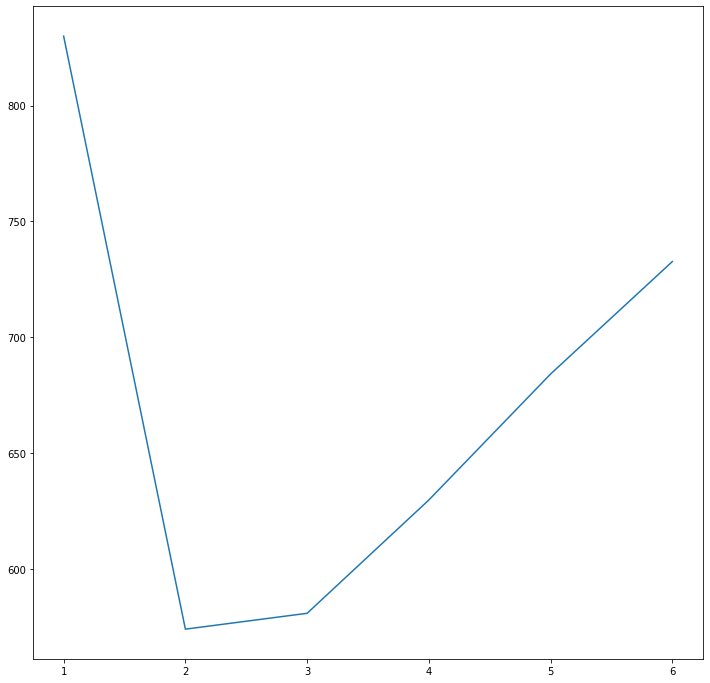

In [30]:
plt.figure()
BICs = []
for n_clusters in range(1,7):
    mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
    mix.fit(X)
    BICs.append(mix.bic(X))

plt.plot(range(1,7),BICs)
plt.show()

Note that the minimum of BIC suggests only two clusters!  Maybe this isn't so surprising.  Looking at our data again, without class labels it's not very easy to see the divide between two of the classes.

[]

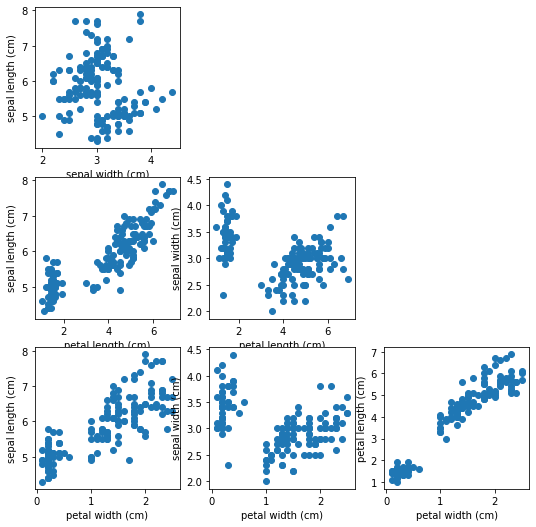

In [31]:
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j])
            axs[i,j].set_xlabel(data['feature_names'][i])
            axs[i,j].set_ylabel(data['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.plot()

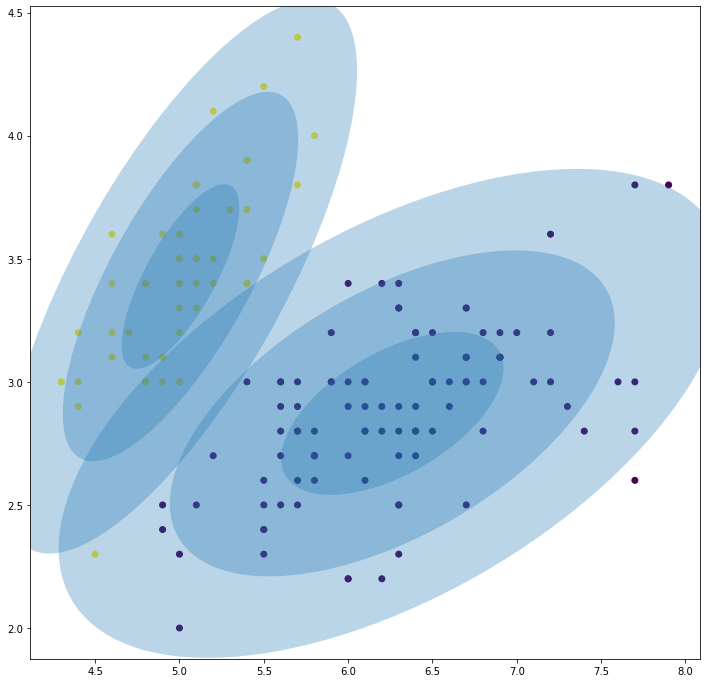

In [32]:
mix = mixture.GaussianMixture(n_components=2,max_iter=1000)
mix.fit(X)

y_pred = mix.predict(X)
plt.scatter(X[:,0],X[:,1],c=y_pred)
for mu,sigma in zip(mix.means_,mix.covariances_):
    plot_ellipse(mu[:2],sigma[:2,:2],alpha=0.3)
plt.show()

This case is a little bit challenging.  To see how BIC can help pick the number of classes, let's make up some data that is more easily separated.

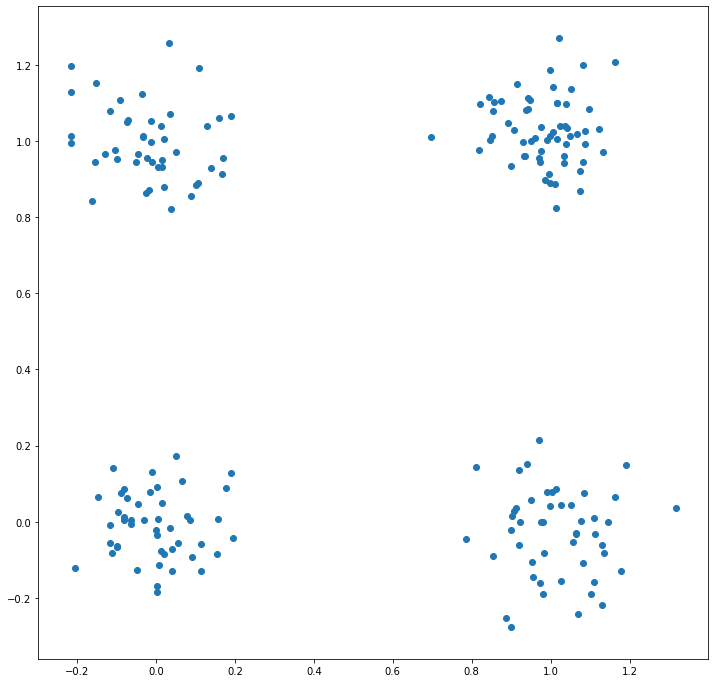

In [33]:
sigma = 0.1
means = np.array([[0,0],[0,1],[1,0],[1,1]])
random_centers = np.random.randint(0,4,200)
X = means[random_centers] + sigma*np.random.randn(200,2)
plt.scatter(X[:,0],X[:,1])
plt.show()

Obviously, we have four distinct clusters.  Let's loop over $k$ as before, and compute the BIC for each.

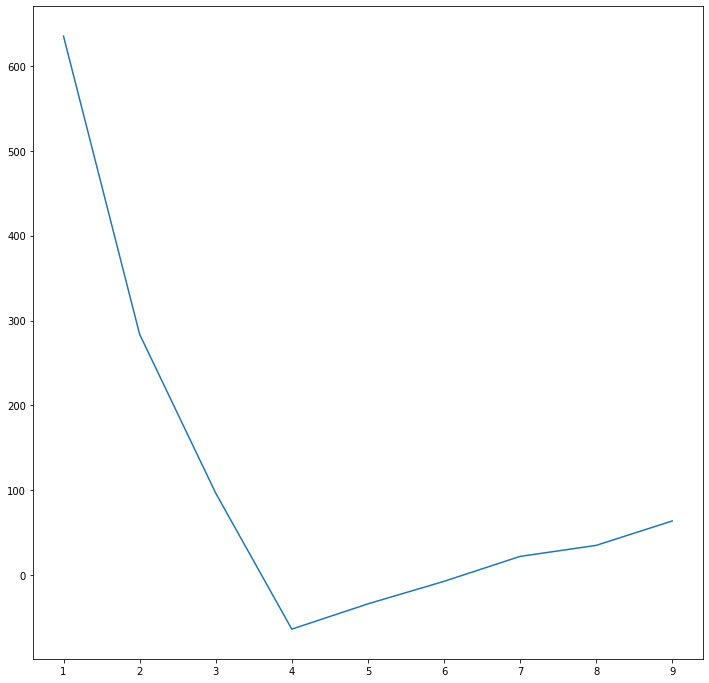

In [34]:
plt.figure()
BICs = []
for n_clusters in range(1,10):
    mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
    mix.fit(X)
    BICs.append(mix.bic(X))
plt.plot(range(1,10),BICs)
plt.show()

Clearly, we have a minimum at $k=4$, so BIC has picked out the correct number of clusters to fit.

What happens if the data becomes a little bit more ambiguous?

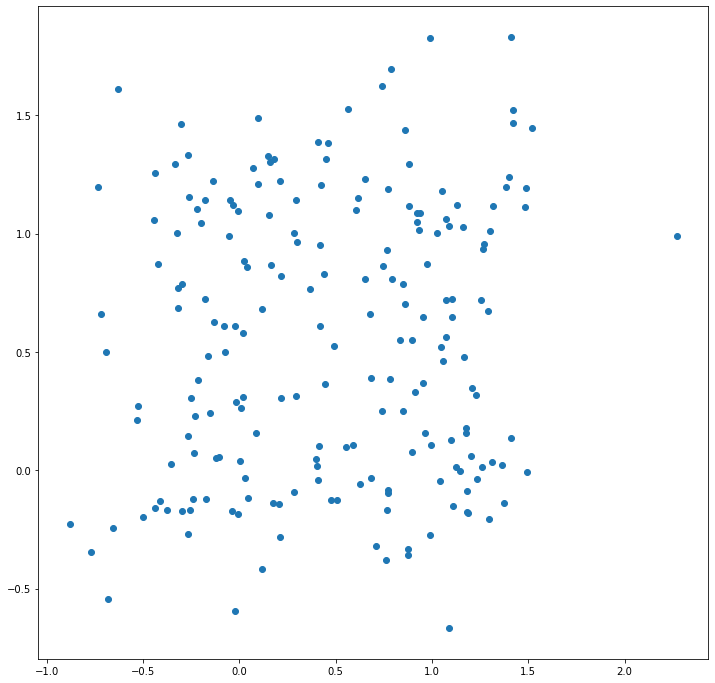

In [35]:
sigma = 0.3
means = np.array([[0,0],[0,1],[1,0],[1,1]])
random_centers = np.random.randint(0,4,200)
X = means[random_centers] + sigma*np.random.randn(200,2)
plt.scatter(X[:,0],X[:,1])
plt.show()

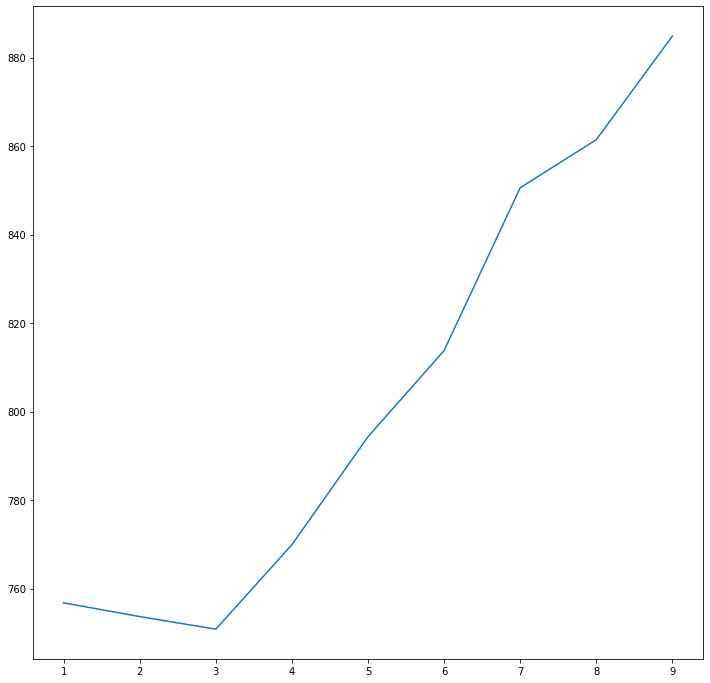

In [36]:
plt.figure()
BICs = []
for n_clusters in range(1,10):
    mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
    mix.fit(X)
    BICs.append(mix.bic(X))
plt.plot(range(1,10),BICs)
plt.show()

Clearly, there isn't enough division between classes to infer that there should be 4 clusters.  Instead BIC implies that we'd be better off combining two of the clusters:

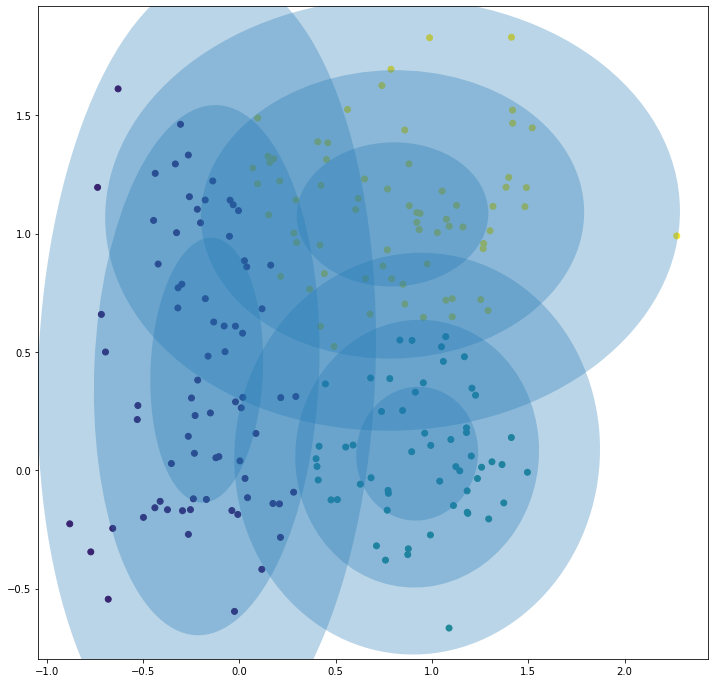

In [37]:
plt.figure()
n_clusters = np.argmin(BICs)+1
mix = mixture.GaussianMixture(n_components=n_clusters,max_iter=1000)
mix.fit(X)
y_pred = mix.predict(X)

plt.scatter(X[:,0],X[:,1],c=y_pred)
for mu,sigma in zip(mix.means_,mix.covariances_):
    plot_ellipse(mu,sigma,alpha=0.3)
    
plt.show()

# MNIST

0.0657639241599022
0.06088668428202893
0.05909313900356597
0.05553461454333143
0.05196804860804943
0.045795238842355444
0.04023044077639884
0.03563979497932373
0.03330482064567982
0.03231181916879847
0.031463386165968915
0.030189314405334757
0.029102382737588375
0.028525122889178866
0.028165909410157102
0.02789786271750927
0.027698345918287622
0.027523248341489344
0.027347674625034027
0.027214238340867326
0.02708089438049083
0.026955736515686866
0.02685159148370966
0.026765502624689266
0.026681756307470036
0.02659721610710976
0.026535908386428306
0.026471456021387528
0.026403093345938846
0.02634679393723924
0.026297008444337133
0.026251328887140497
0.026203727912395558
0.026163668962235147
0.02612878756320223
0.026099581493342176
0.026066500368587514
0.026025416067940125
0.026004751383307132
0.02597366512772885
0.025948449493722714
0.02592694624624354
0.025892712889199563
0.025867112274182605
0.025846192082192035
0.025831777840218645
0.02580355349531833
0.025789757699091385
0.025769877

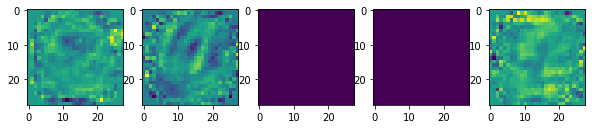

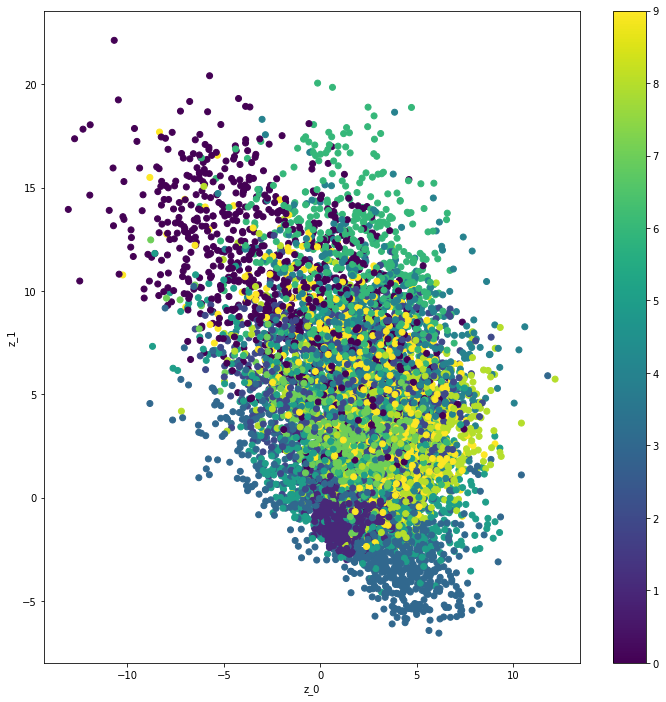

In [51]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y,test_size=10000)

# Extract number of data points, and the height and width of the images for later reshaping
m = X.shape[0]
n = X.shape[1]

h = 28
w = 28

N = 10

X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

from torch.utils.data import TensorDataset

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

latent_dim = 8
intermediate_dim = 128

import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self,n,latent_dim,intermediate_dim):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Encoder,self).__init__()
        self.l1 = nn.Linear(n,intermediate_dim) # Transform from input to hidden layer
        self.l2 = nn.Linear(intermediate_dim,latent_dim)
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        a1 = self.l1(x)
        z1 = torch.relu(a1)   
        
        a2 = self.l2(z1)  
        return a2
    
class Decoder(nn.Module):
    def __init__(self,n,latent_dim,intermediate_dim):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Decoder,self).__init__()
        self.l1 = nn.Linear(latent_dim,intermediate_dim) # Transform from input to hidden layer
        self.l2 = nn.Linear(intermediate_dim,n)
        self.drop = nn.Dropout(p=0.8)
    
    def forward(self,z):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        #a1d = self.drop(z)
        a1 = self.l1(z)
        z1 = torch.relu(a1)   
        
        a2 = self.l2(z1)  
        return a2
    
encoder = Encoder(n,latent_dim,intermediate_dim)
encoder.to(device)

decoder = Decoder(n,latent_dim,intermediate_dim)
decoder.to(device)

for layer in [encoder.l1,encoder.l2,decoder.l1,decoder.l2]:
    layer.weight.data[:] = 0

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam([e for e in encoder.parameters()]+[p for p in decoder.parameters()],lr=1e-3)

gamma = 1.0e-4
epochs = 50
# Loop over the data
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    # Loop over each subset of data
    l = 0
    n_batches = 0
    for d,_ in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        latent = encoder(d)
        reconstruction = decoder(latent)
        
        # Compute the loss
        loss = criterion(reconstruction,d)
        for layer in [encoder.l1,encoder.l2,decoder.l1,decoder.l2]:
            loss += gamma*torch.mean(layer.weight**2)
        
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
        l += loss.item()
        n_batches += 1
    print(l/n_batches)
    
# Encoder weights (Good features to extract)
fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(10,10))
for i,ax in enumerate(axs):    
    i = np.random.randint(intermediate_dim)
    ax.imshow([e for e in encoder.parameters()][0][i,:].detach().cpu().numpy().reshape((28,28)))#,vmin=-0.3,vmax=0.4)

plt.show()

reconstruction = decoder(encoder(X_test))
z_intermediate = encoder(X_test).detach().cpu().numpy()
plt.scatter(z_intermediate[:,0],z_intermediate[:,1],c=y_test.detach().cpu().numpy())
plt.colorbar()
plt.xlabel('z_0')
plt.ylabel('z_1')
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [52]:
mix = mixture.GaussianMixture(n_components=10,max_iter=1000)
mix.fit(z_intermediate)

y_pred = mix.predict(z_intermediate)
#plt.scatter(z_intermediate[:,0],z_intermediate[:,1],c=y_pred)
#for mu,sigma in zip(mix.means_,mix.covariances_):
#    plot_ellipse(mu[:2],sigma[:2,:2],alpha=0.3)
#plt.show()
    

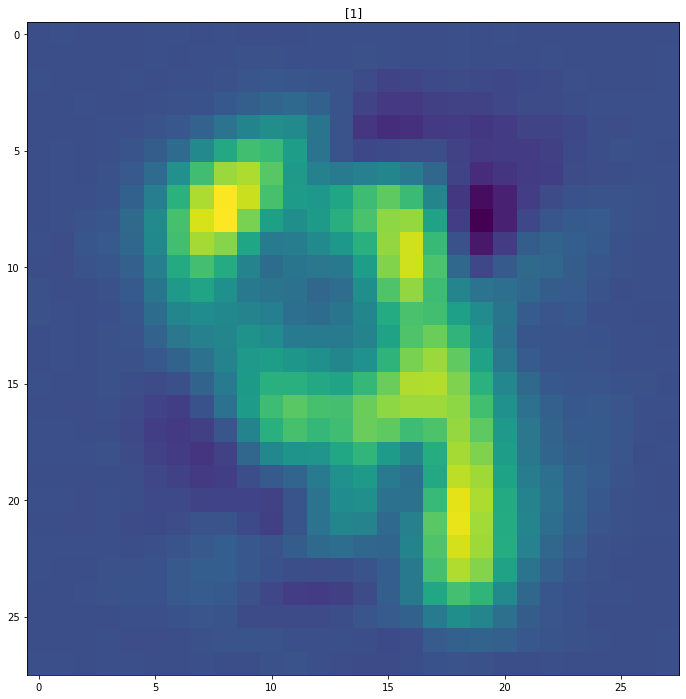

In [59]:
z, cluster_index = mix.sample()

z = torch.from_numpy(z).to(torch.float32).to(device)
x_pred = decoder(z).reshape((28,28)).detach().cpu().numpy()
plt.imshow(x_pred)
plt.title(cluster_index)
plt.show()


In [40]:
mix.sample()

(array([[18.23573037, -2.51178135]]), array([5]))